### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempPropAll/'
treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 152 ms, sys: 56.1 ms, total: 208 ms
Wall time: 231 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [6]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [7]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [8]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

### Diabetes

In [9]:
%%time
after = 1
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after).reset_index(drop = True)


CPU times: user 3.52 s, sys: 27.4 ms, total: 3.55 s
Wall time: 3.54 s


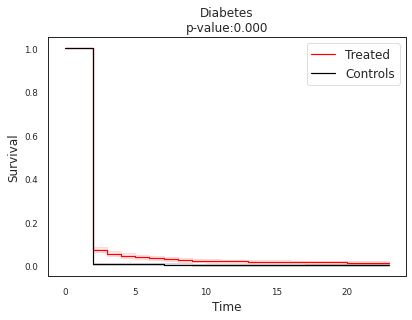

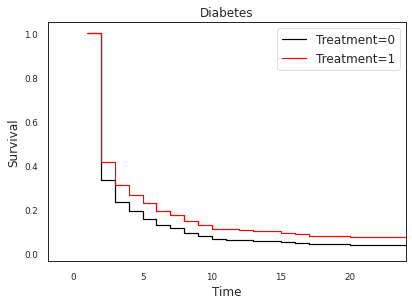

In [10]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title)

In [11]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       27.759888  1.373444e-07  22.795698

In [12]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -0.226           0.165       -1.372    0.170
Gender               0.019           0.043        0.449    0.654
Total Cost           0.008           0.010        0.815    0.415
Tobacco use         -0.005           0.064       -0.085    0.932
Obesity             -0.029           0.049       -0.597    0.550
Hypertension         0.071           0.053        1.331    0.183
Hypothyroid         -0.024           0.074       -0.327    0.744
Disease Count        1.004           0.219        4.585    0.000
Treatment           -0.219           0.048       -4.579    0.000

### ER

In [13]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [14]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.43 s, sys: 40.6 ms, total: 3.47 s
Wall time: 3.47 s


In [15]:
treated[treated.PERS_ID == "2578414"]['ALLOW_IP']

13    5819.85
14       0.00
15       0.00
16       0.00
17       0.00
18       0.00
19       0.00
20       0.00
21       0.00
22       0.00
23       0.00
24       0.00
25       0.00
26       0.00
Name: ALLOW_IP, dtype: float64

In [16]:
survTr[survTr.PERS_ID == "2578414"]

PERS_ID   T  E  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  \
1  2578414  14  0               87       9012       0.0   5819.85        0   

   CC_ALZHEIMER  CC_ALZHEIMER_PLUS  ...  ER_BIN  ER_BIN2  ER_C  IP_BIN  \
1             0                  1  ...       0      0.0     0       1   

   IP_BIN2  IP_C  MBR_GNDR     MYR  PREGNANCY  Treatment  
1      1.0     1       1.0  201705        0.0          1  

[1 rows x 86 columns]

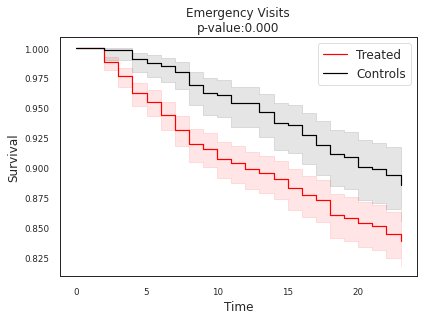

In [17]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [18]:
lrsumm

test_statistic        p   -log2(p)
Emergency Visits       15.557187  0.00008  13.608797

In [19]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -2.423           0.372       -6.508    0.000
Gender              -0.437           0.101       -4.336    0.000
Total Cost           0.097           0.026        3.750    0.000
Tobacco use          0.521           0.120        4.347    0.000
Obesity             -0.347           0.110       -3.154    0.002
Hypertension        -0.086           0.122       -0.707    0.479
Hypothyroid         -0.170           0.154       -1.101    0.271
Disease Count        3.976           0.481        8.272    0.000
Treatment            0.170           0.118        1.441    0.149

### IP

In [20]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.43 s, sys: 14.9 ms, total: 3.44 s
Wall time: 3.44 s


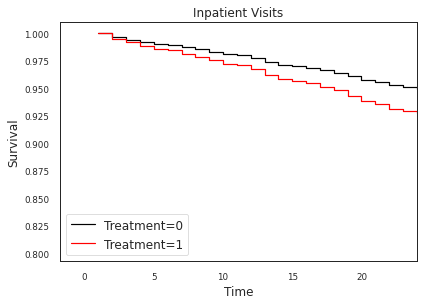

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [23]:
lrsumm

test_statistic         p   -log2(p)
Inpatient Visits       15.707136  0.000074  13.723195

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                  0.403           0.521        0.774    0.439
Gender               0.124           0.122        1.014    0.311
Total Cost           0.250           0.038        6.587    0.000
Tobacco use          0.347           0.150        2.307    0.021
Obesity             -0.311           0.133       -2.347    0.019
Hypertension        -0.152           0.153       -0.991    0.322
Hypothyroid         -0.205           0.179       -1.142    0.254
Disease Count        4.843           0.511        9.482    0.000
Treatment            0.379           0.151        2.507    0.012

### Acute Care IP OR ER

In [25]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [26]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.44 s, sys: 0 ns, total: 3.44 s
Wall time: 3.44 s


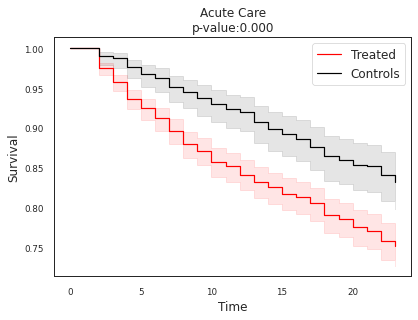

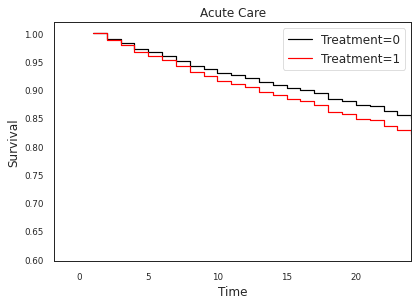

In [27]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title)

In [28]:
lrsumm

test_statistic         p   -log2(p)
Acute Care       20.959667  0.000005  17.701812

In [29]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.368           0.319       -4.293    0.000
Gender              -0.162           0.080       -2.034    0.042
Total Cost           0.141           0.022        6.476    0.000
Tobacco use          0.473           0.099        4.768    0.000
Obesity             -0.304           0.089       -3.427    0.001
Hypertension        -0.139           0.098       -1.416    0.157
Hypothyroid         -0.280           0.127       -2.199    0.028
Disease Count        4.349           0.383       11.347    0.000
Treatment            0.189           0.094        2.011    0.044

### Load all Log Rank Sums in a matrix

In [30]:
from pathlib import Path
p = Path('./res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('./res/tabs/all_logrank.csv')


In [31]:
df2

logRank statistic       p-value  RMST difference
Diabetes                  27.759888  1.373444e-07         0.477560
Emergency Visits          15.557187  8.004676e-05        -0.977056
Inpatient Vistis          15.707136  7.394465e-05        -0.619078
Acute Care                20.959667  4.690549e-06        -1.425278